In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import torch.optim as optim
from tqdm import tqdm
import pickle
import seaborn as sns
from itertools import chain

from gnn_model import StationFlowGCN, StationFlowGAT
from train_gnn import(
    train_gnn_model,
    eval_gnn_model,
    regul_edge_node_flow
)
from utils.station_network import StationNetworkSimul
from utils.data import get_degraded_network_loader, create_degraded_networks
from utils.plot import(
    boxplot_node_metric,
    boxplot_node_metric_per_line,
    plot_true_predicted,
    plot_predicted_ape,
)
from utils.metrics import (
    get_metric_per_node_per_network,
    MAPE_loss,
    WAPE_loss,
    WMAPE_loss,
)

In [ ]:
df_stations = pd.read_csv('data/pau_challenge/plan du métro.csv')
df_stations = df_stations[~df_stations['vers Ligne'].isin(['\xa01', '\xa07', '\xa02', '\xa08', '\xa06'])]

df_pos = pd.read_csv("data/pau_challenge/position gps des stations de métro.csv")

#Removing Malsesherbes RER Station
df_pos = df_pos.drop([151])

df_flow = pd.read_csv('data/pau_challenge/passagers.csv')
df_flow['nombre'] = df_flow['nombre'].astype(float)
test_network = StationNetworkSimul(df_stations=df_stations, df_pos=df_pos)

In [7]:
#UNCOMMENT TO GENERATE DATA

# test_network.set_edges_weights()
# test_network.set_nodes_traffic(test_network.network_graph, df_flow=df_flow)

# data_dir = "graph_dataset/"
# for i in range(1,11):
#     create_degraded_networks(test_network, df_flow, num_delete=i, num_degraded=100, data_dir=data_dir)

In [5]:
data_dir = "graph_dataset/"

train_degraded_graphs = {i : [] for i in range(1,11)}
dev_degraded_graphs = {i : [] for i in range(1,11)}
test_degraded_graphs = {i : [] for i in range(1,11)}

train_test_ratio = 0.9
dev_train_ratio = 0.1

for i in range(1,3):
    folder_path = os.path.join(data_dir, f'delete_{i}')
    all_files = [file_path for file_path in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file_path))]
    degraded_graphs = []
    for file_path in all_files:
        with open(os.path.join(folder_path, file_path), 'rb') as f:
            new_net = pickle.load(f)
        degraded_graphs.append(new_net)
    
    train_split_idx = int(train_test_ratio*len(all_files))
    dev_split_idx = int(dev_train_ratio*train_split_idx)

    dev_degraded_graphs[i].extend(degraded_graphs[:dev_split_idx])
    train_degraded_graphs[i].extend(degraded_graphs[dev_split_idx:train_split_idx])
    test_degraded_graphs[i].extend(degraded_graphs[train_split_idx:])

## GCNConv Models

In [6]:
train_config = dict(
    epochs = 20,
    lr = 0.001,
    criterion = torch.nn.L1Loss(),
    metrics = dict(
        MAE=torch.nn.L1Loss(),
        MAPE=MAPE_loss()
    )
)

### Using node position as input

In [385]:
target_name = 'traffic'
node_feature_names=['x', 'y']

train_loader = get_degraded_network_loader(train_degraded_graphs, target_name=target_name, node_feature_names=node_feature_names, shuffle=True)
dev_loader = get_degraded_network_loader(dev_degraded_graphs, target_name=target_name, node_feature_names=node_feature_names, shuffle=True)
test_loader = get_degraded_network_loader(test_degraded_graphs, target_name=target_name, node_feature_names=node_feature_names, shuffle=True)

In [ ]:
input_dim = train_loader.dataset[0].x.shape[1]
output_dim = 1

nodes_gnn_model = StationFlowGCN(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
)

train_gnn_model(nodes_gnn_model, train_config, train_loader, dev_loader)


In [72]:
test_metrics = eval_gnn_model(nodes_gnn_model, test_loader,train_config)
print("\t".join([f"{metric_name}: {metric_value}" for metric_name, metric_value in test_metrics.items()]))

MAE: 10514.5009765625	MAPE: 0.7372737526893616


torch.Size([392, 1])


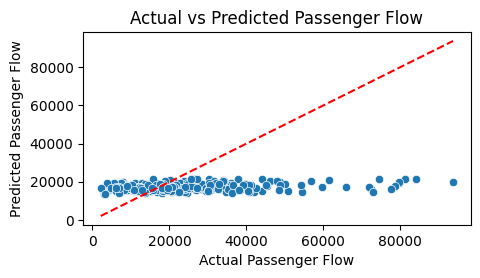

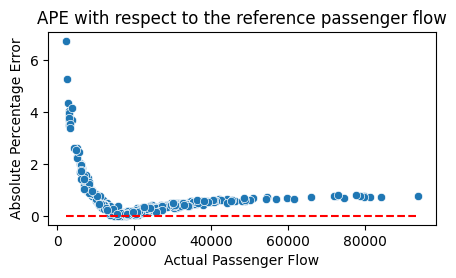

In [75]:
# test_data = random.choice(test_loader.dataset)
test_data = test_loader.dataset[0]
x, edge_index = test_data.x, test_data.edge_index
output = nodes_gnn_model(x, edge_index)
print(output.shape)
actual_flows = test_data.y
predicted_flows = output.detach().squeeze(1)

plot_true_predicted(predicted_flows, actual_flows)
plot_predicted_ape(predicted_flows, actual_flows)


In [65]:
from gnn_model import StationFlowGCN2

In [ ]:
input_dim = train_loader.dataset[0].x.shape[1]
output_dim = 1

nodes_gnn_model2 = StationFlowGCN2(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
)

train_node_gnn_model(nodes_gnn_model2, config, train_loader, dev_loader)


In [67]:
test_metrics2 = eval_node_gnn_model(nodes_gnn_model, test_loader,config)
print("\t".join([f"{metric_name}: {metric_value}" for metric_name, metric_value in test_metrics2.items()]))

MAE: 10524.771484375	MAPE: 0.7599213719367981


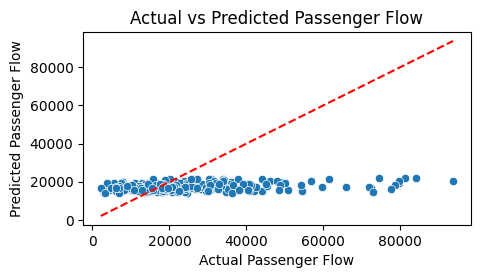

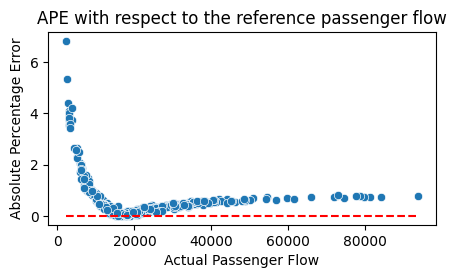

In [68]:
# test_data = random.choice(test_loader.dataset)
test_data = test_loader.dataset[0]
x, edge_index = test_data.x, test_data.edge_index
output, _ = nodes_gnn_model(x, edge_index)

actual_flows = test_data.y
predicted_flows = output.detach().squeeze(1)

plot_true_predicted(predicted_flows, actual_flows)
plot_predicted_ape(predicted_flows, actual_flows)

### Using node embedding as input

#### Initialized + updated during training

#####  Unweighted edges

In [7]:
loader_config = dict(
    node_target_name = 'traffic',
    edge_target_name = 'traffic',
    shuffle=True
)

total_train_degraded_graphs = list(chain.from_iterable([train_degraded_graphs[i] for i in range(1,11)]))
total_dev_degraded_graphs = list(chain.from_iterable([dev_degraded_graphs[i] for i in range(1,11)]))
total_test_degraded_graphs = list(chain.from_iterable([test_degraded_graphs[i] for i in range(1,11)]))

train_loader = get_degraded_network_loader(total_train_degraded_graphs, **loader_config)
dev_loader = get_degraded_network_loader(total_dev_degraded_graphs, **loader_config)
test_loader = get_degraded_network_loader(total_test_degraded_graphs, **loader_config)

NameError: name 'train_degraded_graphs' is not defined

In [ ]:
input_dim = 100
output_dim = 1

nodes_gnn_model = StationFlowGCN(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
    embeddings='initialized'
)

train_gnn_model(nodes_gnn_model, train_config, train_loader, dev_loader)

In [ ]:
# mae_plot = []
# for n_del, degraded_nets in test_degraded_graphs.items():
#     loader = get_degraded_network_loader(degraded_nets, **loader_config)
#     metrics = eval_gnn_model(nodes_gnn_model, loader,train_config)
#     mae_plot.append(metrics['node']['MAPE']*100)

# plt.plot(range(1,11), mae_plot)
# plt.title('MAPE w.r.t. the number of edges deleted')
# plt.xlabel('Num. deleted')
# plt.ylabel('MAPE (%)')

In [ ]:
test_metrics = eval_gnn_model(nodes_gnn_model, test_loader,train_config)
print("\t".join([f"{metric_name}: {metric_value}" for metric_name, metric_value in test_metrics.items()]))

In [ ]:
# random_idx = np.random.randint(0, len(test_loader))
# test_data = test_loader.dataset[random_idx]
test_data = test_loader.dataset[18]
x, edge_index = test_data.x, test_data.edge_index
node_output, edge_output  = nodes_gnn_model(x, edge_index)

node_actual_flows = test_data.y
edge_actual_flows = test_data.ye

node_predicted_flows= node_output.detach().squeeze(1)
edge_predicted_flows= edge_output.detach().squeeze(1)

current_edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
removed_edges = list(set(test_network.network_graph.edges) - set(current_edges))

removed_edges_name = [
    f'{test_network.reverse_network_stations[edge[0]]["title"]} ({test_network.reverse_network_stations[edge[0]]["group"]}) -> {test_network.reverse_network_stations[edge[1]]["title"] } ({test_network.reverse_network_stations[edge[1]]["group"]})'
    for edge in removed_edges
    ]

plot_true_predicted(node_predicted_flows, node_actual_flows, removed_edges_name=removed_edges_name)
plot_true_predicted(edge_predicted_flows, edge_actual_flows, removed_edges_name=removed_edges_name)
# plot_predicted_ape(predicted_flows, actual_flows, removed_edges_name=removed_edges_name)

##### Using edges weights (based on node position)

In [ ]:
loader_config = dict(
    node_target_name = 'traffic',
    edge_target_name = 'traffic',
    edge_feature_names = ['weight'],
    shuffle=True
)

total_train_degraded_graphs = list(chain.from_iterable([train_degraded_graphs[i] for i in range(1,11)]))
total_dev_degraded_graphs = list(chain.from_iterable([dev_degraded_graphs[i] for i in range(1,11)]))
total_test_degraded_graphs = list(chain.from_iterable([test_degraded_graphs[i] for i in range(1,11)]))


train_loader = get_degraded_network_loader(total_train_degraded_graphs, **loader_config)
dev_loader = get_degraded_network_loader(total_dev_degraded_graphs, **loader_config)
test_loader = get_degraded_network_loader(total_test_degraded_graphs, **loader_config)

In [ ]:
input_dim = 100
output_dim = 1

nodes_gnn_model = StationFlowGCN(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
    embeddings='initialized'
)

train_gnn_model(nodes_gnn_model, train_config, train_loader, dev_loader)

In [ ]:
test_metrics = eval_gnn_model(nodes_gnn_model, test_loader, train_config)
print("\t".join([f"{metric_name}: {metric_value}" for metric_name, metric_value in test_metrics.items()]))

In [ ]:
metric = MAPE_loss(reduction='none')
df_ape_per_node_per_network = get_metric_per_node_per_network(nodes_gnn_model, test_loader, metric, test_network)

In [ ]:
boxplot_node_metric(df_ape_per_node_per_network, node_idx=12, network_simul=test_network, metric_name='APE')
plt.show()

In [ ]:
boxplot_node_metric_per_line(df_ape_per_node_per_network, '7', test_network, 'APE')
plt.show()

In [ ]:
test_data = test_loader.dataset[18]
x, edge_index = test_data.x, test_data.edge_index
node_output, edge_output  = nodes_gnn_model(x, edge_index)

node_actual_flows = test_data.y
edge_actual_flows = test_data.ye

node_predicted_flows= node_output.detach().squeeze(1)
edge_predicted_flows= edge_output.detach().squeeze(1)

current_edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
removed_edges = list(set(test_network.network_graph.edges) - set(current_edges))

removed_edges_name = [
    f'{test_network.reverse_network_stations[edge[0]]["title"]} ({test_network.reverse_network_stations[edge[0]]["group"]}) -> {test_network.reverse_network_stations[edge[1]]["title"] } ({test_network.reverse_network_stations[edge[1]]["group"]})'
    for edge in removed_edges
    ]

plot_true_predicted(node_predicted_flows, node_actual_flows, removed_edges_name=removed_edges_name)
plot_predicted_ape(node_predicted_flows, actual_flows)
plot_true_predicted(edge_predicted_flows, edge_actual_flows, removed_edges_name=removed_edges_name)

#### Using Node2Vec embeddings as input

In [14]:
from torch_geometric.nn import Node2Vec

In [15]:
node_idx = torch.tensor([i for i in sorted(test_network.network_graph.nodes)], dtype=torch.int)
tensor_edges = torch.tensor([
    [edge[0] for edge in sorted(test_network.network_graph.edges)],
    [edge[1] for edge in sorted(test_network.network_graph.edges)]
    ], dtype=torch.long)
init_data_graph = Data(x=node_idx, edge_index=tensor_edges)

In [24]:
model_n2v = Node2Vec(
    init_data_graph.edge_index,
    embedding_dim=100,
    walks_per_node=10,
    walk_length=20,
    context_size=10,
    p=1.0,
    q=1.0,
    num_negative_samples=10,
)

ImportError: 'Node2Vec' requires either the 'pyg-lib' or 'torch-cluster' package

In [ ]:
loader_n2v = model_n2v.loader(batch_size=128, shuffle=True)
optimizer_n2v = optim.Adam(model_n2v.parameters(), lr=0.01)

In [ ]:
model_n2v.train()
for pos_rw, neg_rw in loader_n2v:
    optimizer_n2v.zero_grad()
    loss = model_n2v.loss(pos_rw, neg_rw)
    loss.backward()
    optimizer_n2v.step()

In [ ]:
embeddings_n2v = model_n2v()
isinstance(embeddings_n2v, torch.Tensor)

In [ ]:
loader_config = dict(
    node_target_name = 'traffic',
    edge_target_name = 'traffic',
    shuffle=True
)

total_train_degraded_graphs = list(chain.from_iterable([train_degraded_graphs[i] for i in range(1,11)]))
total_dev_degraded_graphs = list(chain.from_iterable([dev_degraded_graphs[i] for i in range(1,11)]))
total_test_degraded_graphs = list(chain.from_iterable([test_degraded_graphs[i] for i in range(1,11)]))


train_loader = get_degraded_network_loader(total_train_degraded_graphs, **loader_config)
dev_loader = get_degraded_network_loader(total_dev_degraded_graphs, **loader_config)
test_loader = get_degraded_network_loader(total_test_degraded_graphs, **loader_config)

In [ ]:
input_dim = 100
output_dim = 1

nodes_gnn_model = StationFlowGCN(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
    embeddings=embeddings_n2v,
    freeze=True
)

train_gnn_model(nodes_gnn_model, train_config, train_loader, dev_loader)

In [ ]:
test_metrics = eval_gnn_model(nodes_gnn_model, test_loader,train_config)
print("\t".join([f"{metric_name}: {metric_value}" for metric_name, metric_value in test_metrics.items()]))

## GATConv Models

In [ ]:
train_config = dict(
    epochs = 20,
    lr = 0.01,
    criterion = dict(
        node=torch.nn.L1Loss(),
        edge=torch.nn.L1Loss(),
        # regul=regul_edge_node_flow(),
    ),
    metrics = dict(
        MAE=torch.nn.L1Loss(),
        MAPE=MAPE_loss()
    )
)

### Using node embedding as input

#### Initialized + updated during training

#####  Unweighted edges

In [ ]:
loader_config = dict(
    node_target_name = 'traffic',
    edge_target_name = 'traffic',
    shuffle=True
)

total_train_degraded_graphs = list(chain.from_iterable([train_degraded_graphs[i] for i in range(1,11)]))
total_dev_degraded_graphs = list(chain.from_iterable([dev_degraded_graphs[i] for i in range(1,11)]))
total_test_degraded_graphs = list(chain.from_iterable([test_degraded_graphs[i] for i in range(1,11)]))


train_loader = get_degraded_network_loader(total_train_degraded_graphs, **loader_config)
dev_loader = get_degraded_network_loader(total_dev_degraded_graphs, **loader_config)
test_loader = get_degraded_network_loader(total_test_degraded_graphs, **loader_config)

In [ ]:
input_dim = 100
output_dim = 1

nodes_gnn_model = StationFlowGAT(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
    embeddings='initialized',
    num_heads=4
)

train_gnn_model(nodes_gnn_model, train_config, train_loader, dev_loader)

In [ ]:
test_metrics = eval_gnn_model(nodes_gnn_model, test_loader,train_config)
print("\t".join([f"{metric_name}: {metric_value}" for metric_name, metric_value in test_metrics.items()]))

#####  Weighted edges (based on node position)

In [ ]:
loader_config = dict(
    node_target_name = 'traffic',
    edge_target_name = 'traffic',
    edge_feature_names = ['weight'],
    shuffle=True
)

total_train_degraded_graphs = list(chain.from_iterable([train_degraded_graphs[i] for i in range(1,11)]))
total_dev_degraded_graphs = list(chain.from_iterable([dev_degraded_graphs[i] for i in range(1,11)]))
total_test_degraded_graphs = list(chain.from_iterable([test_degraded_graphs[i] for i in range(1,11)]))


train_loader = get_degraded_network_loader(total_train_degraded_graphs, **loader_config)
dev_loader = get_degraded_network_loader(total_dev_degraded_graphs, **loader_config)
test_loader = get_degraded_network_loader(total_test_degraded_graphs, **loader_config)

In [ ]:
input_dim = 100
output_dim = 1

nodes_gnn_model = StationFlowGAT(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
    embeddings='initialized',
    edge_dim=1
)

train_gnn_model(nodes_gnn_model, train_config, train_loader, dev_loader)

In [ ]:
test_metrics = eval_gnn_model(nodes_gnn_model, test_loader,train_config)
print("\t".join([f"{metric_name}: {metric_value}" for metric_name, metric_value in test_metrics.items()]))

## Explainability

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.metric import fidelity

In [ ]:
config = dict(
    epochs = 5,
    lr = 0.001,
    criterion = torch.nn.L1Loss(),
    metrics = dict(
        MAE=torch.nn.L1Loss(),
        MAPE=MAPE_loss()
    )
)

In [ ]:
node_target_name = 'traffic'
node_feature_names=['x', 'y']

train_loader = get_degraded_network_loader(train_degraded_graphs, node_target_name=node_target_name, node_feature_names=node_feature_names, shuffle=True)
dev_loader = get_degraded_network_loader(dev_degraded_graphs, node_target_name=node_target_name, node_feature_names=node_feature_names, shuffle=True)
test_loader = get_degraded_network_loader(test_degraded_graphs, node_target_name=node_target_name, node_feature_names=node_feature_names, shuffle=True)

In [ ]:
input_dim = train_loader.dataset[0].x.shape[1]
output_dim = 1

nodes_gnn_model = StationFlowGCN(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
)

train_gnn_model(nodes_gnn_model, config, train_loader, dev_loader)


In [ ]:
explainer = Explainer(
    model=nodes_gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

data = test_loader.dataset[0]
idx_chtl_4 = test_network.network_stations['Châtelet']['4']

explanation = explainer(data.x, data.edge_index, index=idx_chtl_4)
print(explanation.edge_mask)
print(explanation.node_mask)

In [ ]:
node_labels = nx.get_node_attributes(test_network.network_graph, 'title')
explanation.visualize_graph(node_labels=node_labels)